# Homeostatic STDP: SORF model

[![Download JupyterNotebook](https://img.shields.io/badge/Download-Notebook-orange?style=for-the-badge&logo=Jupyter)](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/SORF.ipynb) [![Download JupyterNotebook](https://img.shields.io/badge/Open_in-Colab-blue?style=for-the-badge&logo=Jupyter)](https://colab.research.google.com/github/ANNarchy/ANNarchy.github.io/blob/master/notebooks/SORF.ipynb)

In [1]:
#!pip install ANNarchy

Reimplementation of the SORF model published in:

> Carlson, K.D.; Richert, M.; Dutt, N.; Krichmar, J.L., "Biologically plausible models of homeostasis and STDP: Stability and learning in spiking neural networks," in Neural Networks (IJCNN), The 2013 International Joint Conference on , vol., no., pp.1-8, 4-9 Aug. 2013. doi: 10.1109/IJCNN.2013.6706961

In [2]:
import numpy as np
import ANNarchy as ann

from tqdm import tqdm

ANNarchy 4.8 (4.8.3) on darwin (posix).


Hyperparameters:

In [3]:
nb_neuron = 4 # Number of exc and inh neurons
size = (32, 32) # input size
freq = 1.2 # nb_cycles/half-image
nb_stim = 40 # Number of grating per epoch
nb_epochs = 20 # Number of epochs
max_freq = 28. # Max frequency of the poisson neurons
T = 10000. # Period for averaging the firing rate

Neuron type:

In [4]:
# Izhikevich Coba neuron with AMPA, NMDA and GABA receptors
RSNeuron = ann.Neuron(
    parameters = dict(
        a = 0.02,
        b = 0.2,
        c = -65.,
        d = 8.,

        tau_ampa = 5.,
        tau_nmda = 150.,
        tau_gabaa = 6.,
        tau_gabab = 150.,

        vrev_ampa = 0.0,
        vrev_nmda = 0.0,
        vrev_gabaa = -70.0,
        vrev_gabab = -90.0,
     ) ,
    equations = [
        # Inputs
        ann.Variable("""
            I = g_ampa * (vrev_ampa - v) + g_nmda * nmda(v, -80.0, 60.0) * (vrev_nmda -v) + g_gabaa * (vrev_gabaa - v) + g_gabab * (vrev_gabab -v)
        """),

        # Midpoint scheme
        ann.Variable("dv/dt = (0.04 * v + 5.0) * v + 140.0 - u + I", init=-65., min=-90., method='midpoint'),
        ann.Variable("du/dt = a * (b*v - u)", init=-13., method='midpoint'),
        
        # Conductances
        ann.Variable("tau_ampa * dg_ampa/dt = -g_ampa", method='exponential'),
        ann.Variable("tau_nmda * dg_nmda/dt = -g_nmda", method='exponential'),
        ann.Variable("tau_gabaa * dg_gabaa/dt = -g_gabaa", method='exponential'),
        ann.Variable("tau_gabab * dg_gabab/dt = -g_gabab", method='exponential'),
    ],
    spike = "v >= 30.",
    reset = """
        v = c
        u += d
        g_ampa = 0.0
        g_nmda = 0.0
        g_gabaa = 0.0
        g_gabab = 0.0
    """,
    functions = """
        nmda(v, t, s) = ((v-t)/(s))^2 / (1.0 + ((v-t)/(s))^2)
    """,
    refractory=1.0
)

Synapse:

In [5]:
# STDP with homeostatic regulation
homeo_stdp = ann.Synapse(
    parameters=dict(
        # STDP
        tau_plus  = 60.,
        tau_minus = 90.,
        A_plus  = 0.000045,
        A_minus = 0.00003,

        # Homeostatic regulation
        alpha = 0.1,
        beta = 50.0, # <- Difference with the original implementation
        gamma = 50.0,
        Rtarget = 10.,
        T = 10000.,
    ),
    equations = [
        # Homeostatic values
        ann.Variable("R = post.r", locality='semiglobal'),
        ann.Variable("K = R/(T * (1. + fabs(1. - R / Rtarget) * gamma))", locality='semiglobal'),

        # Nearest-neighbour
        ann.Variable("stdp = if t_post >= t_pre: ltp else: - ltd"),
        ann.Variable("w += (alpha * w * (1- R/Rtarget) + beta * stdp ) * K", min=0.0, max=10.0),
        
        # Traces
        ann.Variable("tau_plus  * dltp/dt = -ltp", method="exponential"),
        ann.Variable("tau_minus * dltd/dt = -ltd", method="exponential"),
    ],
    pre_spike="""
        g_target += w
        ltp = A_plus
    """,
    post_spike="ltd = A_minus"
)

Network:

In [6]:
# Network
net = ann.Network()

# Input population
OnPoiss = net.create(ann.PoissonPopulation(size, rates=1.0))
OffPoiss = net.create(ann.PoissonPopulation(size, rates=1.0))

# RS neuron for the input buffers
OnBuffer = net.create(size, RSNeuron)
OffBuffer = net.create(size, RSNeuron)

# Connect the buffers
OnPoissBuffer = net.connect(OnPoiss, OnBuffer, ['ampa', 'nmda'])
OnPoissBuffer.connect_one_to_one(ann.Uniform(0.2, 0.6))
OffPoissBuffer = net.connect(OffPoiss, OffBuffer, ['ampa', 'nmda'])
OffPoissBuffer.connect_one_to_one(ann.Uniform(0.2, 0.6))

# Excitatory and inhibitory neurons
Exc = net.create(nb_neuron, RSNeuron)
Inh = net.create(nb_neuron, RSNeuron)
Exc.compute_firing_rate(T)
Inh.compute_firing_rate(T)

# Input connections
OnBufferExc = net.connect(OnBuffer, Exc, ['ampa', 'nmda'], homeo_stdp)
OnBufferExc.connect_all_to_all(ann.Uniform(0.004, 0.015))
OffBufferExc = net.connect(OffBuffer, Exc, ['ampa', 'nmda'], homeo_stdp)
OffBufferExc.connect_all_to_all(ann.Uniform(0.004, 0.015))

# Competition
ExcInh = net.connect(Exc, Inh, ['ampa', 'nmda'], homeo_stdp)
ExcInh.connect_all_to_all(ann.Uniform(0.116, 0.403))

ExcInh.Rtarget = 75.
ExcInh.tau_plus = 51.
ExcInh.tau_minus = 78.
ExcInh.A_plus = -0.000041
ExcInh.A_minus = -0.000015

InhExc = net.connect(Inh, Exc, ['gabaa', 'gabab'])
InhExc.connect_all_to_all(ann.Uniform(0.065, 0.259))

net.compile()

Compiling network 1...  OK 


In [7]:
# Inputs
def get_grating(theta):
    x = np.linspace(-1., 1., size[0])
    y = np.linspace(-1., 1., size[1])
    xx, yy = np.meshgrid(x, y)
    z = np.sin(2.*np.pi*(np.cos(theta)*xx + np.sin(theta)*yy)*freq)
    return np.maximum(z, 0.), -np.minimum(z, 0.0)

# Initial weights
w_on_start = OnBufferExc.w
w_off_start = OffBufferExc.w

# Monitors
m = net.monitor(Exc, 'r')
n = net.monitor(Inh, 'r')
o = net.monitor(OnBufferExc[0], 'w', period=1000.)
p = net.monitor(ExcInh[0], 'w', period=1000.)

# Learning procedure
from time import time
import random
tstart = time()
stim_order = list(range(nb_stim))

for epoch in tqdm(range(nb_epochs)):

    random.shuffle(stim_order)
    
    for stim in stim_order:
    
        # Generate a grating randomly
        rates_on, rates_off = get_grating(np.pi*stim/float(nb_stim))
    
        # Set it as input to the poisson neurons
        OnPoiss.rates  = max_freq * rates_on
        OffPoiss.rates = max_freq * rates_off
    
        # Simulate for 2s
        net.simulate(2000.)
    
        # Relax the Poisson inputs
        OnPoiss.rates  = 1.
        OffPoiss.rates = 1.
    
        # Simulate for 500ms
        net.simulate(500.)
    
print('Done in ', time()-tstart)

# Recordings
datae = m.get('r')
datai = n.get('r')
dataw = o.get('w')
datal = p.get('w')

100%|██████████| 20/20 [02:15<00:00,  6.79s/it]


Done in  135.82723808288574


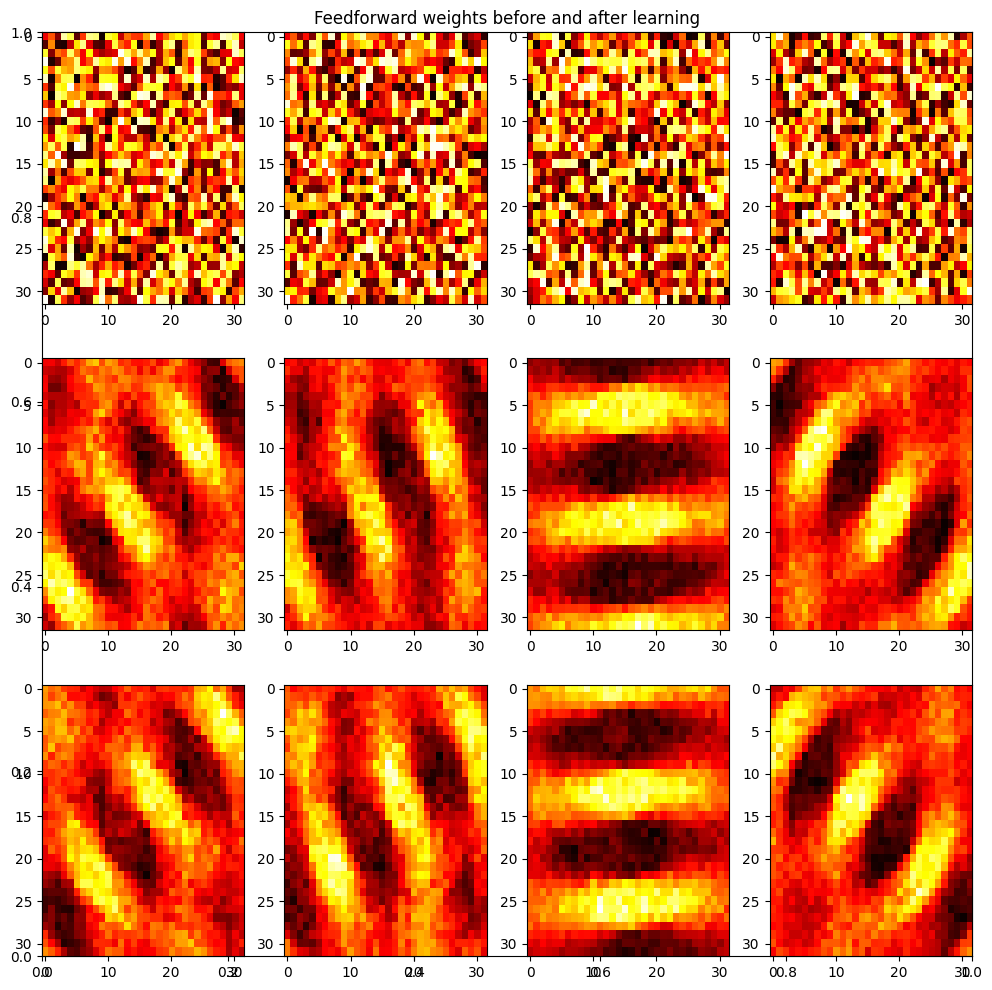

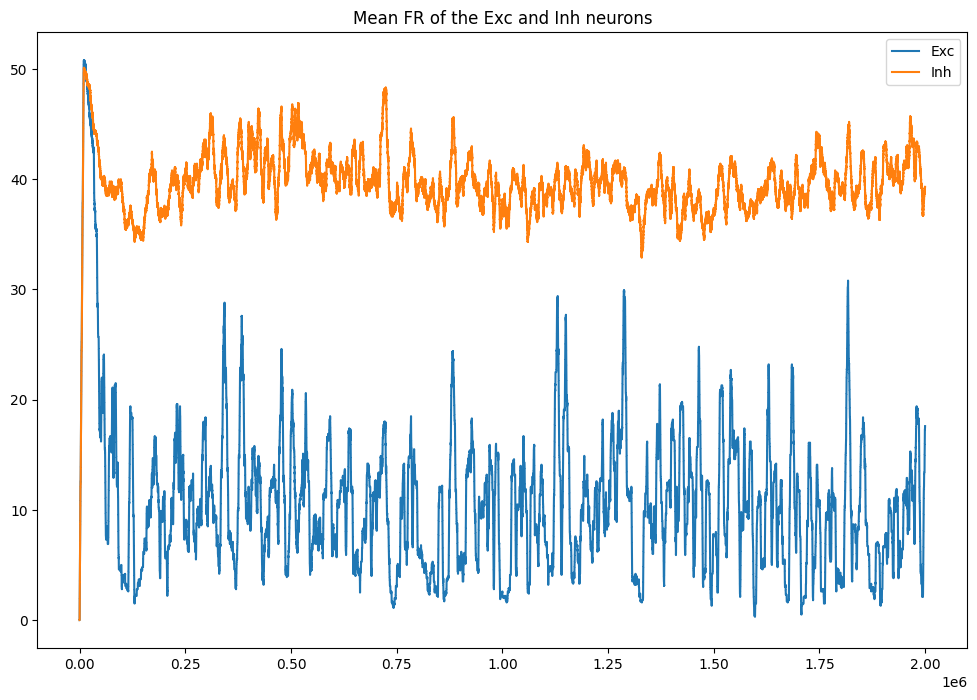

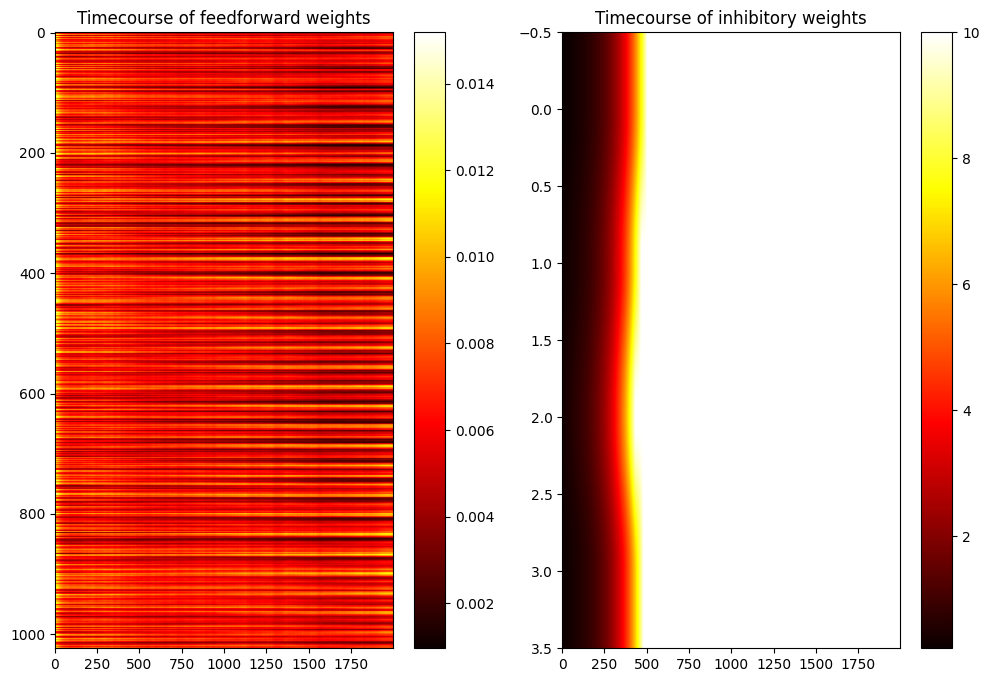

In [8]:
# Final weights
w_on_end = OnBufferExc.w
w_off_end = OffBufferExc.w

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.title('Feedforward weights before and after learning')
for i in range(nb_neuron):
    plt.subplot(3, nb_neuron, i+1)
    plt.imshow((np.array(w_on_start[i])).reshape((32,32)), aspect='auto', cmap='hot')
    plt.subplot(3, nb_neuron, nb_neuron + i +1)
    plt.imshow((np.array(w_on_end[i])).reshape((32,32)), aspect='auto', cmap='hot')
    plt.subplot(3, nb_neuron, 2*nb_neuron + i +1)
    plt.imshow((np.array(w_off_end[i])).reshape((32,32)), aspect='auto', cmap='hot')

plt.figure(figsize=(12, 8))
plt.plot(datae[:, 0], label='Exc')
plt.plot(datai[:, 0], label='Inh')
plt.title('Mean FR of the Exc and Inh neurons')
plt.legend()

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(np.array(dataw, dtype='float').T, aspect='auto', cmap='hot')
plt.title('Timecourse of feedforward weights')
plt.colorbar()
plt.subplot(122)
plt.imshow(np.array(datal, dtype='float').T, aspect='auto', cmap='hot')
plt.title('Timecourse of inhibitory weights')
plt.colorbar()
plt.show()
